#    Project: Cardio Vascular in the US

### Nguyen Vu

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext


import sys
from operator import add


from pyspark import SparkContext
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
import sys
from operator import add

from pyspark.sql.types import *
from pyspark.sql import functions as func

from pyspark.sql import SQLContext

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

sqlContext = SQLContext(sc)

import pyspark.sql.functions as F
import pyspark.ml.evaluation as evals 

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import S
from pyspark.ml.regression import LinearRegression

import numpy as np

In [ ]:
! ls -la 

In [8]:
data = spark.read.csv('U.S._Chronic_Disease_Indicators__Cardiovascular_Disease.csv', header = True)

In [9]:
allcols = data.columns

Important columns for analysis:
* LocationAbbr = State where data is recorded
* Question = Describe what the data value answer. Will be manually classified as mortality vs. hopitalization and everything else. Mortality = Yes serious, Everything else = No serious
* DataValueUnit = Unit of data (%, per 1000, per 10,000, etc.). Will be convert all into 1 common unit = percent
* DataValueType = Rate Value Type (adyjusted for age or not adjusted)
* DataValue = Numeric number
* StratificationCategory1 = describe stratification as gender or race.
* Stratification1 = stratification data: Female, male, black, white, asian, etc.

In [10]:
#Choose important columns to keep
cols2Keep = ['LocationAbbr',
 'Question',
 'DataValueUnit',
 'DataValueType',
 'DataValue',
 'StratificationCategory1',
 'Stratification1',]

cols2Drop = list(set(allcols) - set(cols2Keep))

data = data.drop(*cols2Drop)

data = data.dropna()
data = data.dropDuplicates()

In [11]:
data.dtypes


[('LocationAbbr', 'string'),
 ('Question', 'string'),
 ('DataValueUnit', 'string'),
 ('DataValueType', 'string'),
 ('DataValue', 'string'),
 ('StratificationCategory1', 'string'),
 ('Stratification1', 'string')]

In [12]:
# Split stratification Categories
findmale = data['Stratification1'].like('%Male%')
findfemale = data['Stratification1'].like('%Female%')

findwhite = data['Stratification1'].like('%White%')
findblack = data['Stratification1'].like('%Black%')

data = data.withColumn('gender', (F.when(findmale, 1.0)
                                 .when(findfemale, 0.0)
                                 .otherwise(None)))

data = data.withColumn('race', (F.when(findwhite, 'white')
                                 .when(findblack, 'black')
                                 .when(data['Stratification1'].like('Hispanic'), 'latin')
                                 .when(data['Stratification1'].like('%Overall%'), 'all')
                                 .otherwise('other')))
data = data.drop('Stratification1')

In [13]:
# correct the the data value for rate data
data = data.withColumn('DataValue',data['DataValue'].cast("float").alias('DataValue'))

def dataConverter(message, value):
    if '1,000'in message:
        correctVal = value/1000/10
    elif '10,000'in message:
        correctVal = value/10000/100
    elif '100,000'in message:
        correctVal = value/100000/1000
    elif '%'in message:
        correctVal = value
    else: correctVal = None
    return correctVal

udfPctRate = F.udf(dataConverter, FloatType())

data = data.withColumn('pctRate', udfPctRate(F.col('DataValueUnit'), F.col('DataValue')))



In [20]:
def seriousnessClassification(question): #Mortality Classified as 1, Hospitalization and High Blood Pressure Classified as 0
    if ('Mortality'in question):
        x = 1.0
    elif ('Hospitalization'in question) or ('high blood pressure'in question) or ('holesterol'in question):
        x = 0.0
    else: x = None
    return x

udfSeriousness = F.udf(seriousnessClassification, FloatType())

data = data.withColumn('Seriousness', udfSeriousness(F.col('Question')))




In [24]:
# more data clean up to put types of rate data into buckets
findCrudeRate = data['DataValueType'].like('%Crude%')
findAgeRate = data['DataValueType'].like('%Age-adjusted%')

data = data.withColumn('RateAdjusted', (F.when(findCrudeRate, 0.0)
                                 .when(findAgeRate, 1.0)
                                 .otherwise(None)))


In [25]:
masterDF = data.select(['LocationAbbr', 'StratificationCategory1','gender', 'race', 'pctRate', 'Seriousness', 'RateAdjusted'])

In [26]:
masterDF.dtypes

[('LocationAbbr', 'string'),
 ('StratificationCategory1', 'string'),
 ('gender', 'double'),
 ('race', 'string'),
 ('pctRate', 'float'),
 ('Seriousness', 'float'),
 ('RateAdjusted', 'double')]

In [27]:
masterDF.show(6)

+------------+-----------------------+------+-----+------------+-----------+------------+
|LocationAbbr|StratificationCategory1|gender| race|     pctRate|Seriousness|RateAdjusted|
+------------+-----------------------+------+-----+------------+-----------+------------+
|          KS|         Race/Ethnicity|  null|white|     9.72E-7|        1.0|         1.0|
|          NH|         Race/Ethnicity|  null|white|    1.835E-6|        1.0|         0.0|
|          AL|                 Gender|   0.0|other| 9.930001E-7|        1.0|         1.0|
|          AK|         Race/Ethnicity|  null|white|2.5100002E-7|        1.0|         0.0|
|          LA|                 Gender|   0.0|other|     8.46E-7|        1.0|         1.0|
|          MN|                Overall|  null|  all|     9.44E-7|        1.0|         0.0|
+------------+-----------------------+------+-----+------------+-----------+------------+
only showing top 6 rows



In [33]:
byRaceDF = masterDF.where(~masterDF['race'].isNull()).drop(*['StratificationCategory1', 'gender'])
byGenderDF = masterDF.where(~masterDF['gender'].isNull()).drop(*['StratificationCategory1', 'race'])


In [34]:
#correct Data Type for both DF

byRaceDF = byRaceDF.withColumn('pctRate',data['pctRate'].cast("float").alias('pctRate'))
byGenderDF = byGenderDF.withColumn('pctRate',data['pctRate'].cast("float").alias('pctRate'))

byRaceDF = byRaceDF.withColumn('RateAdjusted',data['RateAdjusted'].cast("float").alias('RateAdjusted'))
byGenderDF = byGenderDF.withColumn('RateAdjusted',data['RateAdjusted'].cast("float").alias('RateAdjusted'))

byGenderDF = byGenderDF.withColumn('gender',data['gender'].cast("float").alias('gender'))


In [35]:
byGenderDF.dtypes

[('LocationAbbr', 'string'),
 ('gender', 'float'),
 ('pctRate', 'float'),
 ('Seriousness', 'float'),
 ('RateAdjusted', 'float')]

In [36]:
byRaceDF.dtypes

[('LocationAbbr', 'string'),
 ('race', 'string'),
 ('pctRate', 'float'),
 ('Seriousness', 'float'),
 ('RateAdjusted', 'float')]

In [37]:
byGenderDF = byGenderDF.dropna()
byRaceDF = byRaceDF.dropna()

In [38]:
byGenderDF.count()

13612

In [39]:
byRaceDF.count()

46607

In [59]:

def addInt():
    return 1.0
addUDF = F.udf(addInt, FloatType())

byRaceDF = byRaceDF.withColumn("intercept", addUDF())
byGenderDF = byGenderDF.withColumn("intercept", addUDF())

In [58]:
byRaceDF.show(3)

+------------+-----+-----------+-----------+------------+---------+
|LocationAbbr| race|    pctRate|Seriousness|RateAdjusted|intercept|
+------------+-----+-----------+-----------+------------+---------+
|          KS|white|    9.72E-7|        1.0|         1.0|      1.0|
|          NH|white|   1.835E-6|        1.0|         0.0|      1.0|
|          AL|other|9.930001E-7|        1.0|         1.0|      1.0|
+------------+-----+-----------+-----------+------------+---------+
only showing top 3 rows



### Race data is chosen for having more data
## Prepare Race Data for machine Learning

In [60]:

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
import numpy as np


strIdx = StringIndexer(inputCols=['LocationAbbr', 'Seriousness', 'race'], outputCols=['State_idx', 'Serious_idx', 'race_idx'])

raceIdx = strIdx.fit(byRaceDF).transform(byRaceDF)

oneHot = OneHotEncoder(inputCols=['State_idx', 'race_idx'], outputCols=['State_vec', 'race_vec'])

raceCoded = oneHot.fit(raceIdx).transform(raceIdx)

assemble = VectorAssembler(inputCols=['RateAdjusted', 'State_vec', 'race_vec', 'intercept'], outputCol = 'features')
raceCoded = assemble.transform(raceCoded)



### Data Inspection

In [42]:
numericCols = ['pctRate',
 'RateAdjusted',
 'State_idx',
 'Serious_idx',
 'race_idx',]

correlations = []
#check pairwise correlation for all columns
for i in numericCols:
    for j in numericCols:
        corr = raceCoded.corr(j, i)
        correlations.append([i,j,corr])

corrMatrix = sc.parallelize(correlations)



In [ ]:
corrMatrix.top(15, lambda x: x[2])

**Correlations Observations**
> Moderate to strong correlation between pctRate and Seriousness Level:
> > Both PctRate and Seriousness Levels are to be used as response thus this is not an issues

> No other significant correlation is observed

In [43]:
raceModelDF = raceCoded.select(['pctRate','Serious_idx', 'features'])

raceModelDF.show(4)

+------------+-----------+--------------------+
|     pctRate|Serious_idx|            features|
+------------+-----------+--------------------+
|     9.72E-7|        0.0|(58,[0,20,56],[1....|
|    1.835E-6|        0.0|(58,[51,56],[1.0,...|
| 9.930001E-7|        0.0|(58,[0,38,54],[1....|
|2.5100002E-7|        0.0|(58,[41,56],[1.0,...|
+------------+-----------+--------------------+
only showing top 4 rows



In [ ]:
raceModelDF.describe(['features']).show()

In [ ]:
raceModelDF.describe(['Serious_idx']).show()

In [70]:
raceModelDF.dtypes

[('pctRate', 'float'), ('Serious_idx', 'double'), ('features', 'vector')]

## Data Prep

In [52]:
raceModelRDD = raceModelDF.rdd.map(lambda x: (x[0], np.array(x[2].toArray())))

In [53]:
raceModelRDD.take(3)

[(9.719999525259482e-07,
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0.])),
 (1.8350000345890294e-06,
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0.])),
 (9.930000715030474e-07,
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0.]))]

In [109]:
#split data to train/test

raceModelDF_train, raceModelDF_test = raceModelDF.randomSplit([0.75, 0.25], seed=1006)



## Manual Multiple Linear regression + SGD to predict PctRate Using RDD


In [199]:
raceModelRDD = raceModelDF_train.rdd.map(lambda x: (x[0], np.array(x[2].toArray())))

d_rdd = len(raceModelRDD.first()[1])
N_rdd = raceModelRDD.count()

In [208]:
# numpy array to store all thetas
# initiate all the theta list
theta_AR = np.random.rand(d)
itr = 0 #initiate at 0
learnRate = (0.0001) #learning Rate
numIter = 400 #maximume Interation
#initiate a cost list to keep trackof cost changes
stSize = 999999
stopcriteria = 0.01
costList = [9999999]

In [209]:
gdStart_RDD = time.time()
raceModelRDD.cache()
while itr < numIter and stSize > stopcriteria:

    raceModelRDD_map = raceModelRDD.map(lambda x: (-(1/N)*(np.multiply(x[1], (x[0] - np.dot(x[1], theta_AR)))), 
                                                   ((x[0] - np.dot(x[1], theta_AR))**2)/N))
    raceModelRDD_reduce = raceModelRDD_map.reduce(lambda a, b: (np.add(a[0], b[0]), a[1]+b[1]))
    
    oldcost = costList[-1]
    
    #SumGradient
    npgd = raceModelRDD_reduce[0]
    cost = raceModelRDD_reduce[1]
    
    #bold driver
    stSize = abs(oldcost - cost)
    if(cost<oldcost):
        new_learingRate=learnRate*1.05
    if(cost>oldcost):
        new_learingRate=learnRate*0.5
    
    # update thetas for the next iteration
    theta_AR -= (npgd)*new_learingRate
    
    # Update Cost
    costList.append(cost)
    
    itr = itr + 1
    
    print('RDD Implementation cost:{:2.4f} Iter:{} Time for 1 Iter= {} secs'.format(cost, itr, time.time()-gdStart_RDD))
    
print('Total RDD Implementation Time for {} Iterations = {}mins'.format(itr, (time.time()-gdStart_RDD)/60))

RDD Implementation cost:836.8034 Iter:1 Time for 1 Iter= 1.6967170238494873 secs
RDD Implementation cost:836.7861 Iter:2 Time for 1 Iter= 3.3365790843963623 secs
RDD Implementation cost:836.7687 Iter:3 Time for 1 Iter= 4.845769166946411 secs
RDD Implementation cost:836.7514 Iter:4 Time for 1 Iter= 6.037713050842285 secs
RDD Implementation cost:836.7340 Iter:5 Time for 1 Iter= 7.7719810009002686 secs
RDD Implementation cost:836.7167 Iter:6 Time for 1 Iter= 8.986366271972656 secs
RDD Implementation cost:836.6994 Iter:7 Time for 1 Iter= 10.241384983062744 secs
RDD Implementation cost:836.6820 Iter:8 Time for 1 Iter= 11.555572986602783 secs
RDD Implementation cost:836.6647 Iter:9 Time for 1 Iter= 13.064329862594604 secs
RDD Implementation cost:836.6474 Iter:10 Time for 1 Iter= 14.450937986373901 secs
RDD Implementation cost:836.6301 Iter:11 Time for 1 Iter= 15.854336023330688 secs
RDD Implementation cost:836.6127 Iter:12 Time for 1 Iter= 17.285988092422485 secs
RDD Implementation cost:836.

RDD Implementation cost:835.0646 Iter:102 Time for 1 Iter= 145.80405282974243 secs
RDD Implementation cost:835.0476 Iter:103 Time for 1 Iter= 147.20488691329956 secs
RDD Implementation cost:835.0305 Iter:104 Time for 1 Iter= 148.5522301197052 secs
RDD Implementation cost:835.0134 Iter:105 Time for 1 Iter= 149.8402030467987 secs
RDD Implementation cost:834.9963 Iter:106 Time for 1 Iter= 151.24532198905945 secs
RDD Implementation cost:834.9793 Iter:107 Time for 1 Iter= 152.53425908088684 secs
RDD Implementation cost:834.9622 Iter:108 Time for 1 Iter= 153.88925504684448 secs
RDD Implementation cost:834.9451 Iter:109 Time for 1 Iter= 155.24118900299072 secs
RDD Implementation cost:834.9280 Iter:110 Time for 1 Iter= 156.63528203964233 secs
RDD Implementation cost:834.9110 Iter:111 Time for 1 Iter= 157.94112992286682 secs
RDD Implementation cost:834.8939 Iter:112 Time for 1 Iter= 159.27752304077148 secs
RDD Implementation cost:834.8769 Iter:113 Time for 1 Iter= 160.59937620162964 secs
RDD Im

RDD Implementation cost:833.3688 Iter:202 Time for 1 Iter= 283.466096162796 secs
RDD Implementation cost:833.3520 Iter:203 Time for 1 Iter= 284.99452209472656 secs
RDD Implementation cost:833.3352 Iter:204 Time for 1 Iter= 286.3655788898468 secs
RDD Implementation cost:833.3183 Iter:205 Time for 1 Iter= 287.658282995224 secs
RDD Implementation cost:833.3015 Iter:206 Time for 1 Iter= 288.9730689525604 secs
RDD Implementation cost:833.2847 Iter:207 Time for 1 Iter= 290.2670068740845 secs
RDD Implementation cost:833.2679 Iter:208 Time for 1 Iter= 291.6003649234772 secs
RDD Implementation cost:833.2511 Iter:209 Time for 1 Iter= 292.9008071422577 secs
RDD Implementation cost:833.2343 Iter:210 Time for 1 Iter= 294.19964694976807 secs
RDD Implementation cost:833.2174 Iter:211 Time for 1 Iter= 295.49226689338684 secs
RDD Implementation cost:833.2006 Iter:212 Time for 1 Iter= 296.95637106895447 secs
RDD Implementation cost:833.1838 Iter:213 Time for 1 Iter= 298.30073499679565 secs
RDD Implement

RDD Implementation cost:831.6982 Iter:302 Time for 1 Iter= 419.74618792533875 secs
RDD Implementation cost:831.6816 Iter:303 Time for 1 Iter= 421.02656412124634 secs
RDD Implementation cost:831.6651 Iter:304 Time for 1 Iter= 422.34522318840027 secs
RDD Implementation cost:831.6485 Iter:305 Time for 1 Iter= 423.7014470100403 secs
RDD Implementation cost:831.6319 Iter:306 Time for 1 Iter= 425.0501821041107 secs
RDD Implementation cost:831.6153 Iter:307 Time for 1 Iter= 426.4172451496124 secs
RDD Implementation cost:831.5988 Iter:308 Time for 1 Iter= 427.8043141365051 secs
RDD Implementation cost:831.5822 Iter:309 Time for 1 Iter= 429.0783269405365 secs
RDD Implementation cost:831.5656 Iter:310 Time for 1 Iter= 430.62995505332947 secs
RDD Implementation cost:831.5491 Iter:311 Time for 1 Iter= 431.9254660606384 secs
RDD Implementation cost:831.5325 Iter:312 Time for 1 Iter= 433.21738481521606 secs
RDD Implementation cost:831.5160 Iter:313 Time for 1 Iter= 434.5427529811859 secs
RDD Impleme

**Total RDD Implementation Time for 400 Iterations = 9.229180220762888 mins**

In [224]:
raceModelRDD_test = raceModelDF_test.rdd.map(lambda x: (x[0], np.array(x[2].toArray())))

N_test = raceModelRDD_test.count()

#add a prediction column
MSE_test = raceModelRDD_test.map(lambda x: (((x[0] - np.dot(x[1], theta_AR))**2)/N_test)).reduce(add)




In [230]:
print('The RMSE is calculated to be {}. Given that the percent rate range from 0 to 100. The RMSE is approximately 28% of the range of signal'.format(np.sqrt(MSE_test))) 

The RMSE is calculated to be 28.25116520950437. Given that the percent rate range from 0 to 100. The RMSE is approximately 28% of the range of signal


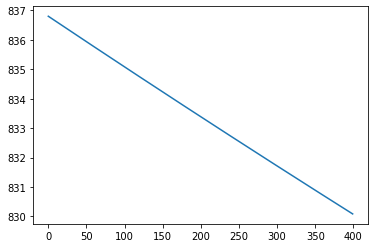

In [237]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_axes()
x = np.array(range(0, len(costList)-1))
MSEcost = costList[1:]
plt.plot(x, MSEcost)

array([2, 3, 4])

## Manual Multiple Linear regression + SGD to predict PctRate Using Data Frame

In [181]:
d = len(raceModelDF_train.rdd.first()[2].toArray())

N = raceModelDF_train.count()

In [182]:
#define a function to get the gradient of the slope. Put all parameters on a numpy array to get it done in 1 pass.
# given that X_Ar is a np array starting with 1 for intercept and , x1, x2, etc.
# thetaAr is a np array starting with theta 0 (for intercept) , theta1 (X1), theta 2 (X2), etc. This array will be preset prior to running the loop

# REMEMBER: x_AR is a sparse Vector, Y is a float, thetaAr is a numpy array
def update_gradient(y, x_Ar, thetaAr):
    x_np = np.array(x_Ar.toArray())
    XdotY = y - np.dot(x_np, thetaAr)
    gdArray = -(2/N)*(np.multiply(x_Ar, XdotY))
    result = gdArray.tolist()
    return result

def update_MSE(y, x_Ar, thetaAr):#to be updated
    x_np = np.array(x_Ar.toArray())
    XdotY = y - np.dot(x_np, thetaAr)
    res = (XdotY**2)/N
    residuals = float(res)
    return residuals 

GdUpdateUDF = F.udf(update_gradient, ArrayType(FloatType()))

MSEudf = F.udf(update_MSE, FloatType())


In [194]:
# numpy array to store all thetas
# initiate all the theta list
theta_AR = np.random.rand(d)
itr = 0 #initiate at 0
learnRate = (0.0001) #learning Rate
numIter = 40 #maximume Interation
#initiate a cost list to keep trackof cost changes
stSize = 999999
stopcriteria = 0.01
costList = [9999999]

In [198]:
gdStart = time.time()
raceModelDFmap_train.cache()
while itr < numIter and stSize > stopcriteria:
    
    oldcost = costList[-1]
    raceModelDFmap_train = raceModelDF_train.withColumn('gradient', GdUpdateUDF(F.col('pctRate'), F.col('features'),F.array([F.lit(i) for i in theta_AR]))).withColumn('cost', MSEudf(F.col('pctRate'), F.col('features'),F.array([F.lit(i) for i in theta_AR])))
    
    gradientList = raceModelDFmap_train.select('gradient').collect()
    #calc new cost
    costArr = raceModelDFmap_train.select('cost').collect()
    #SumGradient
    npgd = np.array(gradientList).sum(axis = 0)[0]
    cost = np.array(costArr).sum(axis = 0)[0]
    
    #bold driver
    stSize = abs(oldcost - cost)
    if(cost<oldcost):
        new_learingRate=learnRate*1.05
    if(cost>oldcost):
        new_learingRate=learnRate*0.5
    
    # update thetas for the next iteration
    theta_AR -= (npgd)*new_learingRate
    
    # Update Cost
    costList.append(cost)
    
    itr = itr + 1
    
    print('cost:{:2.4f} Iter:{} Time for 1 Iter= {} secs'.format(cost, itr, time.time()-gdStart))
    
print(time.time()-gdStart)

cost:846.1846 Iter:1 Time for 1 Iter= 2.9508440494537354 secs
cost:846.1476 Iter:2 Time for 1 Iter= 32.99660086631775 secs
cost:846.1106 Iter:3 Time for 1 Iter= 59.34401893615723 secs
cost:846.0737 Iter:4 Time for 1 Iter= 85.34087109565735 secs
cost:846.0367 Iter:5 Time for 1 Iter= 116.01179695129395 secs
cost:845.9998 Iter:6 Time for 1 Iter= 146.8685441017151 secs
cost:845.9628 Iter:7 Time for 1 Iter= 181.6370849609375 secs
cost:845.9259 Iter:8 Time for 1 Iter= 215.41728115081787 secs
cost:845.8890 Iter:9 Time for 1 Iter= 249.02133584022522 secs
cost:845.8521 Iter:10 Time for 1 Iter= 281.9690408706665 secs
cost:845.8152 Iter:11 Time for 1 Iter= 316.1138770580292 secs
cost:845.7783 Iter:12 Time for 1 Iter= 351.26889991760254 secs
cost:845.7414 Iter:13 Time for 1 Iter= 383.3917751312256 secs
cost:845.7045 Iter:14 Time for 1 Iter= 416.5191099643707 secs
cost:845.6677 Iter:15 Time for 1 Iter= 456.01606583595276 secs
cost:845.6309 Iter:16 Time for 1 Iter= 492.8530378341675 secs
cost:845.59

In [205]:
print('Total DataFrame Implementation Time for 40 Iterations = {}mins'.format(1363.4706048965454/60))

Total DataFrame Implementation Time for 40 Iterations = 22.72451008160909mins


**Total DataFrame Implementation Time for 40 Iterations = 22.72451008160909mins**

> This dataframe implementation is too inefficient due to having to collect multiple times. 

## Use ML Lib in Spark to Run Logistic Regression and SVM

In [239]:
#model to be used to train/test:
# raceModelDF_train, raceModelDF_test

raceModelDF_train.dtypes


[('pctRate', 'float'), ('Serious_idx', 'double'), ('features', 'vector')]

### Use classification to predict degree of seriousness (1 is Death, 0 is Hospital or Just high blood pressure)
#### Logistic Regression

In [242]:
print([raceModelDF_train.count(), raceModelDF_test.count()])

[34840, 11767]


In [243]:
logReg = LogisticRegression(labelCol = 'Serious_idx', featuresCol = 'features')
logReg = logReg.fit(raceModelDF_train)

logRegPredict = logReg.transform(raceModelDF_test)
logRegPredict.groupBy('Serious_idx', 'prediction').count().show()

+-----------+----------+-----+
|Serious_idx|prediction|count|
+-----------+----------+-----+
|        1.0|       1.0|  261|
|        0.0|       1.0|  197|
|        1.0|       0.0| 4798|
|        0.0|       0.0| 6511|
+-----------+----------+-----+



In [252]:
evaluate = evals.MulticlassClassificationEvaluator()
evaluate.setLabelCol('Serious_idx')

[evaluate.evaluate(logRegPredict, {evaluate.metricName:'f1'}),
evaluate.evaluate(logRegPredict, {evaluate.metricName:'accuracy'})]

[0.4527026408855673, 0.5755077759836832]

**Logistic Regression: F1 score is 0.45 while accuracy is 0.575. This model is unfortunately not very good. Perhaps the data is not linearly separatable. Kernel will be considered after trying SVM**

In [254]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="Serious_idx", featuresCol="features")

# Fit the model
lsvcModel = lsvc.fit(raceModelDF_train)

svm_Predict = lsvcModel.transform(raceModelDF_test)
svm_Predict.groupBy('Serious_idx', 'prediction').count().show()




+-----------+----------+-----+
|Serious_idx|prediction|count|
+-----------+----------+-----+
|        1.0|       1.0|   91|
|        0.0|       1.0|   20|
|        1.0|       0.0| 4968|
|        0.0|       0.0| 6688|
+-----------+----------+-----+



In [255]:
[evaluate.evaluate(svm_Predict, {evaluate.metricName:'f1'}),
evaluate.evaluate(svm_Predict, {evaluate.metricName:'accuracy'})]

[0.4303625680281284, 0.5761026599813036]

**SVM Regression: F1 score is 0.43 while accuracy is 0.576. This result is similar with the logistic model. SVM also observed to take twice as long as Logistic regrssion to come to very similar results. Perhaps the data is not linearly separatable. Kernel will be applied Next on SVM.**


In [256]:
byRaceDF.dtypes

[('LocationAbbr', 'string'),
 ('race', 'string'),
 ('pctRate', 'float'),
 ('Seriousness', 'float'),
 ('RateAdjusted', 'float'),
 ('intercept', 'float')]

In [258]:
@F.udf
def addKernel(col1, col2, col3):
    n1 = np.array([col1, col2, col3])
    n2 = (n1 - n1.mean())**2/(2*np.std(n1)**2)
    nsum = n2.sum()
    ker = np.exp(-(nsum))
    kout = float(ker)
    return kout


In [270]:
# Assemble a new set of Vecotor

strIdx = StringIndexer(inputCols=['LocationAbbr', 'Seriousness', 'race'], outputCols=['State_idx', 'Serious_idx', 'race_idx'])

raceIdx = strIdx.fit(byRaceDF).transform(byRaceDF)

raceIdx = raceIdx.withColumn("kernel", addKernel(F.col('RateAdjusted'), F.col('State_idx'), F.col('race_idx')))



In [272]:
raceIdx.columns

['LocationAbbr',
 'race',
 'pctRate',
 'Seriousness',
 'RateAdjusted',
 'intercept',
 'State_idx',
 'Serious_idx',
 'race_idx',
 'kernel']

In [273]:
raceIdx = raceIdx.withColumn('kernel',raceIdx['kernel'].cast("float").alias('kernel'))

In [299]:
oneHot = OneHotEncoder(inputCols=['State_idx', 'race_idx'], outputCols=['State_vec', 'race_vec'])

raceCoded = oneHot.fit(raceIdx).transform(raceIdx)

assemble = VectorAssembler(inputCols=['RateAdjusted', 'State_vec', 'race_vec','kernel', 'intercept'], outputCol = 'features')
raceCoded = assemble.setHandleInvalid("skip").transform(raceCoded)


In [300]:
# split data again into train and test set
raceModelDF_wKernel = raceCoded.select(['Serious_idx', 'features'])
raceModelDF_train_k, raceModelDF_test_k = raceModelDF_wKernel.randomSplit([0.75, 0.25], seed=1006)


In [301]:
raceModelDF_train_k.show(4)

+-----------+--------------------+
|Serious_idx|            features|
+-----------+--------------------+
|        0.0|(60,[0,1,54,58,59...|
|        0.0|(60,[0,1,55,58,59...|
|        0.0|(60,[0,3,58,59],[...|
|        0.0|(60,[0,5,55,58,59...|
+-----------+--------------------+
only showing top 4 rows



In [302]:
# Try SVM again
lsvc = LinearSVC(labelCol="Serious_idx", featuresCol="features")

# Fit the model
lsvcModel = lsvc.fit(raceModelDF_train_k)

svm_Predict = lsvcModel.transform(raceModelDF_test_k)
svm_Predict.groupBy('Serious_idx', 'prediction').count().show()

+-----------+----------+-----+
|Serious_idx|prediction|count|
+-----------+----------+-----+
|        1.0|       1.0|  106|
|        0.0|       1.0|   19|
|        1.0|       0.0| 4922|
|        0.0|       0.0| 6635|
+-----------+----------+-----+



In [303]:
[evaluate.evaluate(svm_Predict, {evaluate.metricName:'f1'}),
evaluate.evaluate(svm_Predict, {evaluate.metricName:'accuracy'})]

[0.43275956152284556, 0.5770416024653313]

**Using the kernel trick, F1 score remains at 0.43 and accuracy remains at 0.577. This model is not very predictive. This may be due to poor selection of the feature variables. There maybe underlying or "missing" features not accounted for. This may be a good candidate to try EM for GMM algorithm to see if we can cluster these data into buckets for future practice**

### Last thing I want to try is to use Race as a response variable to see if we can collectly classify Race using percent of cases, location, and if the case rate has been adjusted for age. I will use NaiveBayes for this

In [307]:
raceCoded.dtypes

[('LocationAbbr', 'string'),
 ('race', 'string'),
 ('pctRate', 'float'),
 ('Seriousness', 'float'),
 ('RateAdjusted', 'float'),
 ('intercept', 'float'),
 ('State_idx', 'double'),
 ('Serious_idx', 'double'),
 ('race_idx', 'double'),
 ('kernel', 'float'),
 ('State_vec', 'vector'),
 ('race_vec', 'vector'),
 ('features', 'vector')]

In [322]:
assemble = VectorAssembler(inputCols=['RateAdjusted', 'State_vec', 'Seriousness', 'pctRate'], outputCol = 'features2')
raceCoded2 = assemble.setHandleInvalid("skip").transform(raceCoded)



In [323]:
# split data again into train and test set
raceModelDF_nbay = raceCoded2.select(['race_idx', 'features2'])
raceModelDF_nbay = raceModelDF_nbay.withColumnRenamed('features2', 'features')

In [324]:
nbay_train_k, nbay_test_k = raceModelDF_nbay.randomSplit([0.75, 0.25], seed=1006)

In [325]:
raceCoded.groupBy('race').count().orderBy(F.col('count').desc()).show()

+-----+-----+
| race|count|
+-----+-----+
|other|21560|
|  all| 7012|
|white| 6897|
|black| 5503|
|latin| 5283|
+-----+-----+



In [326]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='features', labelCol='race_idx', smoothing=1.0, modelType='multinomial')

nbmodel = nb.fit(nbay_train_k)

nbpredict = nbmodel.transform(nbay_test_k)
nbpredict.groupBy('race_idx', 'prediction').count().show()


+--------+----------+-----+
|race_idx|prediction|count|
+--------+----------+-----+
|     2.0|       0.0| 1751|
|     1.0|       1.0|   29|
|     0.0|       1.0|   13|
|     1.0|       0.0| 1731|
|     3.0|       1.0|    3|
|     0.0|       0.0| 5475|
|     4.0|       0.0| 1287|
|     3.0|       0.0| 1390|
|     4.0|       1.0|    3|
+--------+----------+-----+



In [327]:
evaluate.setLabelCol('race_idx')

[evaluate.evaluate(nbpredict, {evaluate.metricName:'f1'}),
evaluate.evaluate(nbpredict, {evaluate.metricName:'accuracy'})]

[0.30527224351139043, 0.4711521999657593]

In [331]:
#recall, precision
[5475/(5475+13), 5475/(5475+1751+1731+1287+1390)]

[0.997631195335277, 0.4706034038164002]

**In trying to predict race, F1 score of the prediction is 0.3 and accuracy is 0.47. 
This model is not doing a good job predicting multiple races. Only the top 2 most frequent category is able to be classified. Even though, the recall for Other race (coded = 0) is  0.99, the precision is terrible at 0.47. Poor model may be caused by noisy and unbalance trainining data. Also,part of the poor model may also because the race/ethnicity was labeled base on the analyst pre-conceived notion. A better approach may be to simply stratify the original data set to 'Gender' and 'Ethnicity', then perform unsupervised learning over the data (GMM perhaps) to let the data natural cluster rather than forcing the data to be classified.**

Thank you for a wonderful class. 

Nguyen Vu